<h3> Documentation for Thread Files : </h3>
1. 8 threads running the simulation (agents) parallel. Each thread would write into it's own file (thread_i.txt) where i>=0 && i<8.

2. The first line contains the total number of agents and ratio of Milli seconds to frames.  (Ex: 8501, 0.05). So in this example 1 frame = 20 milliseconds.

3. The format of the other lines is: sec, agent_id, agent_type, has_luggage, is_disabled, X, Y, Z, velocity, queue_id, lookUp_X, lookUp_Y. (lookUp_X, lookUp_Y - gives the next position of the agent)

4. Regarding the heights: For floor f, the Z = 3 * ( f -1 ) + 1. So for the first floor, Z=1, second Z= 4, third Z= 7 etc.



<h3> Major Things to Do </h3>

- Map Entrance/Exit data onto Agent Data?

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml # For reading building.yaml as a Python dict


# Matplotlib Config
%matplotlib inline
plt.style.use('fivethirtyeight')

In [8]:
print(pd.__version__) # Should be 0.20.1
print(np.__version__) # Should be 1.12.1
print(yaml.__version__) # Should be 3.12 - If you don't have this use 'pip install pyyaml' into your command line/terminal

0.19.1
1.11.1
3.12


In [9]:
### Read thread_x file and convert to a PANDAS dataframe (and one CSV)
### Column Names for our dataframe

col_names = ['sec', 
             'agent_id',
             'agent_type',
             'has_luggage',
             'is_disabled',
             'X', 
             'Y',
             'Z',
             'velocity',
             'queue_id',
             'lookUp_X',
             'lookUp_Y']

# Convert the file into a Pandas DF. Ignore first line (header=0) and use col_names as headers instead.
# Play around with this df and generalize the outcomes for the other 7 files

df = pd.read_csv('Files/Agents/thread_0.txt', header=0, names=col_names)
df.head(10)

,sec,agent_id,agent_type,has_luggage,is_disabled,X,Y,Z,velocity,queue_id,lookUp_X,lookUp_Y
0,70201,0,4,0,0,105.955,20.712,7.0,0.586,-1,105.500,22.130
1,70201,8,4,0,0,82.995,14.989,1.0,0.720,-1,83.495,18.265
2,70201,16,1,0,0,49.066,-72.638,1.0,0.737,-1,49.822,-72.954
3,70201,24,1,0,0,111.617,28.309,10.0,2.944,-1,108.060,30.175
4,70201,32,1,0,0,108.920,34.867,4.0,1.386,-1,103.980,32.855
5,70201,40,1,0,0,76.772,-59.873,16.0,1.432,-1,71.840,-59.505
6,70201,48,1,0,0,-77.964,-28.577,16.0,1.249,-1,-73.100,-27.350
7,70201,56,1,0,0,111.189,34.401,7.0,1.639,-1,109.625,33.800
8,70201,64,1,0,0,97.345,17.189,4.0,1.177,-1,100.460,12.700
9,70201,72,4,0,0,126.732,26.644,7.0,0.603,-1,127.970,30.270


In [92]:
# Code for merging all 8 files into one big dataframe - Don't think this approach is correct
# as each file (probably?) represents a seperate simulation.

'''
file_number = list(range(0,8))
main_df = pd.DataFrame()

### Iterate over the 8 files and add each individual files dataframe to one large df called main_df

for i in file_number:
    df = pd.read_csv('Files/Agents/thread_' + str(i) + '.txt',header=0,names=col_names)
    main_df = main_df.append(df,ignore_index=True)
    
main_df.shape
'''

In [136]:
x=df.query('agent_id==0')
x.head(10)


,sec,agent_id,agent_type,has_luggage,is_disabled,X,Y,Z,velocity,queue_id,lookUp_X,lookUp_Y
0,70201,0,4,0,0,105.955,20.712,7.0,0.586,-1,105.50,22.13
462,70202,0,4,0,0,105.849,21.283,7.0,0.586,-1,105.50,23.40
928,70203,0,4,0,0,105.778,21.864,7.0,0.586,-1,105.50,23.40
1397,70204,0,4,0,0,105.700,22.515,7.0,0.586,-1,103.40,26.18
1869,70205,0,4,0,0,105.427,23.325,7.0,1.173,-1,103.40,26.18
2344,70206,0,4,0,0,105.104,23.914,7.0,0.586,-1,100.85,26.18
2821,70207,0,4,0,0,104.716,24.353,7.0,0.586,-1,100.85,26.18
3300,70208,0,4,0,0,104.151,24.829,7.0,0.586,-1,100.85,26.18
3782,70209,0,4,0,0,103.407,25.226,7.0,1.173,-1,100.85,26.18
4263,70210,0,4,0,0,102.385,25.373,7.0,1.173,-1,92.25,26.95


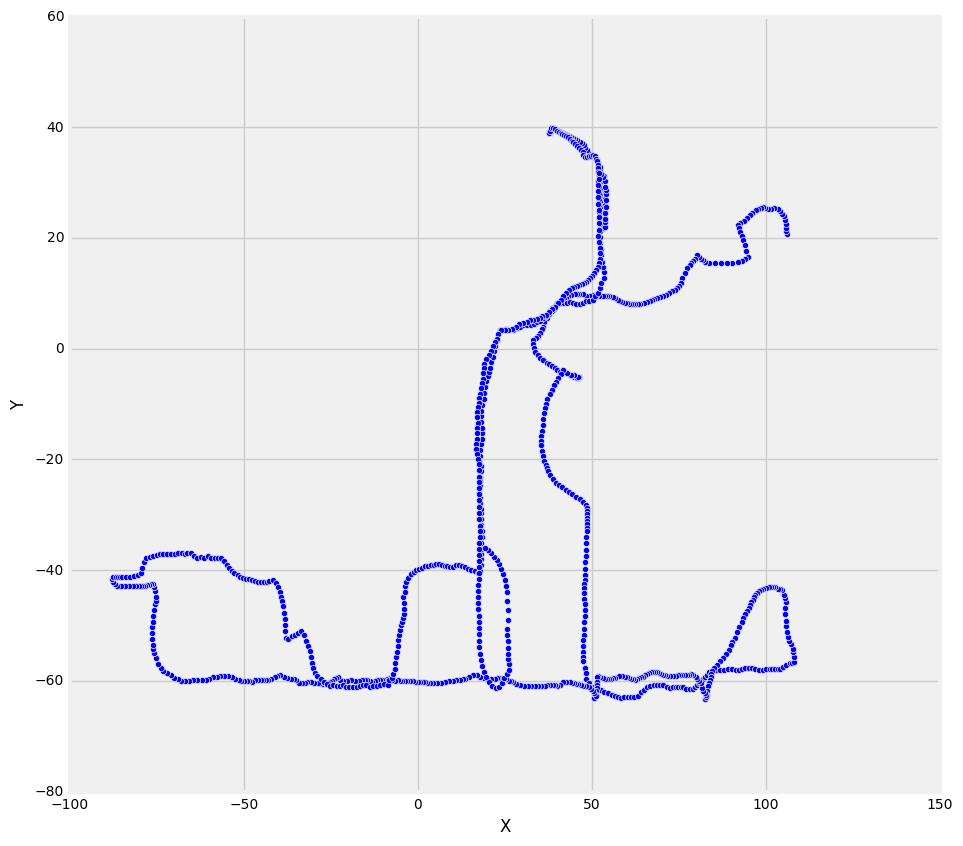

In [120]:
# Sort dataframe by Agent_ID and TimeStamp
#df = df.sort_values(by=['agent_id','sec'])
#df.head(20)

# Plot one agent
df[df['agent_id'] == 0].plot.scatter(x='X',y='Y',figsize=(10,10))

In [122]:
# Convert Z values to floors (don't know if useful or not)

# Function to convert Z value to floor
def z_to_floor(z_value):
    return (z_value + 2) / 3

#df['Z'] = df['Z'].map(lambda x : z_to_floor(x))
#print(df['Z'].value_counts())

# Not all Z values are integers. Are these agents between floors? On Elevators or Stairs or something?
# If we use floor division instead of float division in the conversion function (i.e. use // instead of /), we'd
# end up with integers but not sure how accurate that would be as it rounds down

In [123]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [124]:
from mpl_toolkits.mplot3d import Axes3D


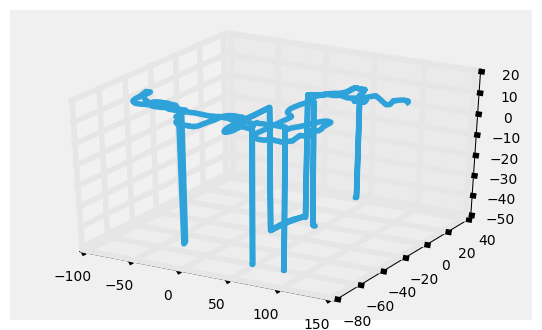

In [125]:

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot(x['X'], x['Y'], x['Z'])


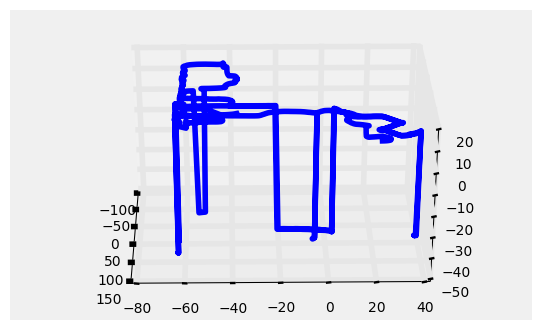

In [134]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(x['X'], x['Y'], x['Z'], rstride=5, cstride=5)

# rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(0.001)